In [3]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras

# Data loading and generation

In [4]:
training_set_annotations = pd.read_csv('training_data/annotations.csv').drop('Unnamed: 0', axis=1).set_index('file_path').fillna(method = 'ffill')
training_set_annotations.columns

C:\Users\Legion\AppData\Local\Temp\ipykernel_24284\4155054217.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  training_set_annotations = pd.read_csv('training_data/annotations.csv').drop('Unnamed: 0', axis=1).set_index('file_path').fillna(method = 'ffill')


Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

In [5]:
training_set_annotations.iloc[:5]

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
file_path,,,,,,,,,,,,,,,,,,,,,
0.jpg,0.687850,0.406274,0.314865,0.379392,0.620647,0.412994,0.761774,0.416354,0.378714,0.389473,...,0.462714,0.594446,0.637451,0.833023,0.298068,0.806135,0.451173,0.759744,0.449278,0.880060
1.jpg,0.670135,0.364272,0.311972,0.348424,0.613085,0.367441,0.736695,0.376950,0.375362,0.357933,...,0.502149,0.579801,0.587723,0.795333,0.365858,0.792163,0.486298,0.731943,0.473624,0.890418
2.jpg,0.677678,0.363642,0.321914,0.363642,0.618875,0.378343,0.739421,0.378343,0.392480,0.378343,...,0.495388,0.557697,0.633572,0.760566,0.351316,0.757625,0.492447,0.731164,0.492447,0.819368
3.jpg,0.679435,0.388143,0.333574,0.388143,0.625035,0.407575,0.753278,0.399802,0.391861,0.403689,...,0.540470,0.564235,0.683322,0.757330,0.387974,0.772870,0.523991,0.730122,0.537096,0.815296
4.jpg,0.695055,0.412721,0.335883,0.396271,0.610061,0.412721,0.755374,0.415463,0.385233,0.407238,...,0.451037,0.675933,0.631994,0.807534,0.324914,0.802055,0.468362,0.767785,0.460699,0.904908


In [6]:
class DataGenerator(keras.utils.Sequence):
    def __init__(
        self,
        df: pd.DataFrame,
        images_path: str,
        batch_size: int,
        shuffle: bool = True,
        keys: list = None,
    ):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = [i for i in df.index]
        if keys is not None:
            self.indexes = [i for i in keys]
        self.datalen = len(self.indexes)
        self.images_path = images_path
        self.images = np.array([self._load_image(index) for index in self.indexes])
        self.keypoints = df.loc[self.indexes].to_numpy()
        self.indexes = np.arange(self.datalen)
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def _load_image(self, path: str) -> np.array:
        return cv2.cvtColor(
            cv2.imread(self.images_path + "/" + path), cv2.COLOR_BGR2GRAY
        )[:, :, np.newaxis]

    def __getitem__(self, index):
        # get batch indexes from shuffled indexes
        batch_indexes = self.indexes[
            index * self.batch_size : (index + 1) * self.batch_size
        ]
        keypoints = self.keypoints[batch_indexes]
        images = self.images[batch_indexes] # TODO: add augmentations later on
        return images, keypoints

    def __len__(self):
        # Denotes the number of batches per epoch
        return self.datalen // self.batch_size

    def on_epoch_end(self):
        # Updates indexes after each epoch
        self.indexes = np.arange(self.datalen)
        if self.shuffle:
            np.random.shuffle(self.indexes)


gen = DataGenerator(training_set_annotations, "training_data", 32)
print("INPUT SHAPE", gen[0][0][0].shape)
print("OUTPUT SHAPE", gen[0][1][0].shape)
print(len(gen))

INPUT SHAPE (288, 288, 1)
OUTPUT SHAPE (30,)
220


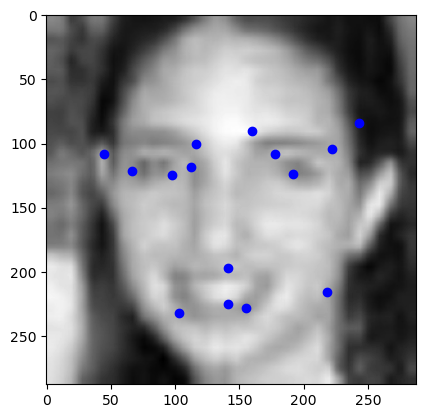

In [70]:
def display_image_with_keypoints(img: np.array, keypoints: list):
    fig, ax = plt.subplots()
    ax.imshow(img, cmap='gray')
    keyps_reshaped = keypoints.reshape(-1, 2)
    ax.scatter(keyps_reshaped[:,0] * img.shape[1], keyps_reshaped[:,1] * img.shape[0], color='blue')
    plt.show()
    
imgs, keyps = gen[0]
display_image_with_keypoints(imgs[0], keyps[0])

# Model training

In [24]:
BATCH_SIZE = 32
EPOCHS = 3

In [30]:
from sklearn.model_selection import train_test_split

train_val_keys, test_keys = train_test_split(training_set_annotations.index, test_size = 0.2)
train_keys, val_keys = train_test_split(train_val_keys, test_size=0.2)
training_set = DataGenerator(training_set_annotations, 'training_data', BATCH_SIZE, keys=train_keys)
validation_set = DataGenerator(training_set_annotations, 'training_data', BATCH_SIZE, keys=val_keys)

test_set = DataGenerator(training_set_annotations, 'training_data', BATCH_SIZE, keys = test_keys)

### Model 1

In [31]:
from keras.models import Sequential, Model
from keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D

INPUT_SHAPE = (288, 288, 1)

model = Sequential()

model.add(Convolution2D(128, (3, 3), input_shape = INPUT_SHAPE, activation = 'leaky_relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Convolution2D(64, (3, 3), activation = 'tanh'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Convolution2D(32, (3, 3), activation = 'leaky_relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Convolution2D(16, (3, 3), activation = 'tanh'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(64, activation = 'leaky_relu'))
model.add(Dense(30, activation = 'sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 286, 286, 128)     1280      
                                                                 
 batch_normalization_8 (Bat  (None, 286, 286, 128)     512       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 143, 143, 128)     0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 141, 141, 64)      73792     
                                                                 
 batch_normalization_9 (Bat  (None, 141, 141, 64)      256       
 chNormalization)                                                
                                                      

In [32]:
model.compile(optimizer='adam', 
              loss='mean_squared_error')

In [33]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='checkpoint.keras',
    monitor='val_loss',
    mode='max',
    save_best_only=True)

In [34]:
model.fit(training_set, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=validation_set, callbacks=[model_checkpoint_callback])

Epoch 1/3
140/140 [==============================] - 708s 5s/step - loss: 0.0054 - val_loss: 0.0028
Epoch 2/3
140/140 [==============================] - 702s 5s/step - loss: 0.0012 - val_loss: 0.0014
Epoch 3/3
140/140 [==============================] - 702s 5s/step - loss: 9.9082e-04 - val_loss: 0.0010


In [35]:
model.evaluate(test_set)

44/44 [==============================] - 44s 1s/step - loss: 0.0011


0.0010756877018138766

In [36]:
img = test_set[0][0][1]
res = model.predict(np.array([img]))

1/1 [==============================] - 0s 248ms/step


In [56]:
res

array([[0.7064931 , 0.37515754, 0.3005477 , 0.3713936 , 0.6016499 ,
        0.382343  , 0.75097907, 0.37513196, 0.36367396, 0.3923267 ,
        0.25141692, 0.41863757, 0.567707  , 0.2878244 , 0.85631144,
        0.34767115, 0.4040103 , 0.33175057, 0.16788891, 0.34808025,
        0.49854767, 0.6794077 , 0.678036  , 0.8289163 , 0.34245825,
        0.8078213 , 0.5142975 , 0.8022741 , 0.4971909 , 0.86582017]],
      dtype=float32)

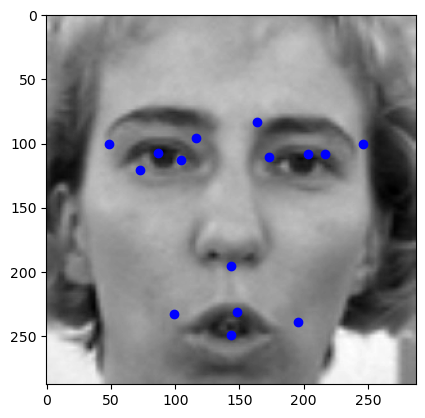

In [71]:
display_image_with_keypoints(img, res)

# Filters

In [53]:
keypoints_names = list(dict.fromkeys(["_".join(index_name.split("_")[:-1]) for index_name in training_set_annotations.columns]))
keypoints_names

['left_eye_center',
 'right_eye_center',
 'left_eye_inner_corner',
 'left_eye_outer_corner',
 'right_eye_inner_corner',
 'right_eye_outer_corner',
 'left_eyebrow_inner_end',
 'left_eyebrow_outer_end',
 'right_eyebrow_inner_end',
 'right_eyebrow_outer_end',
 'nose_tip',
 'mouth_left_corner',
 'mouth_right_corner',
 'mouth_center_top_lip',
 'mouth_center_bottom_lip']

left_eye_center


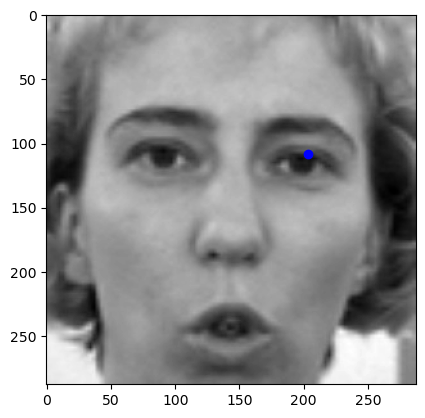

right_eye_center


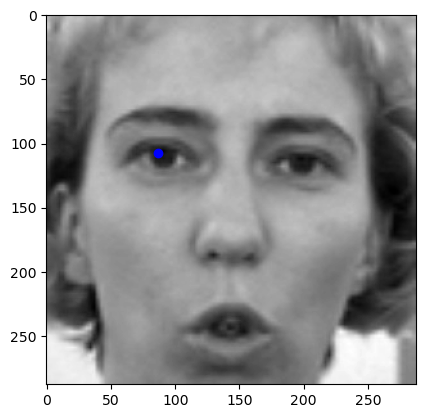

left_eye_inner_corner


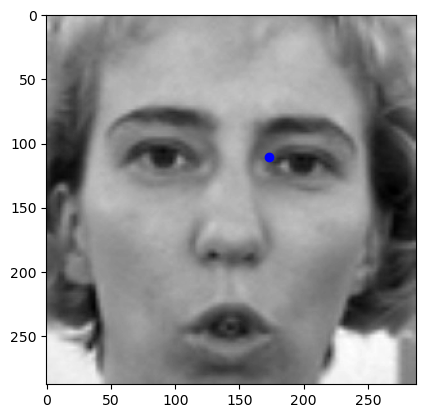

left_eye_outer_corner


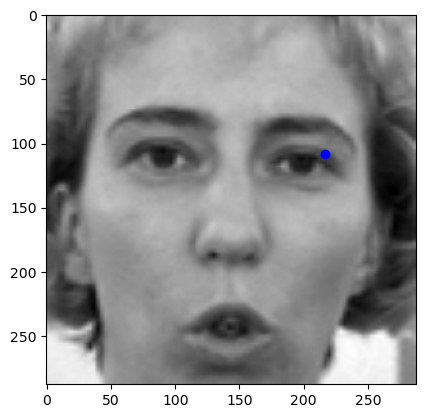

right_eye_inner_corner


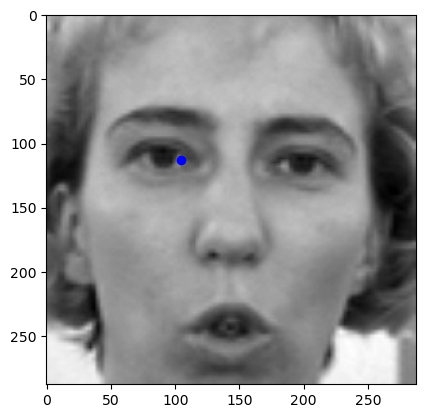

right_eye_outer_corner


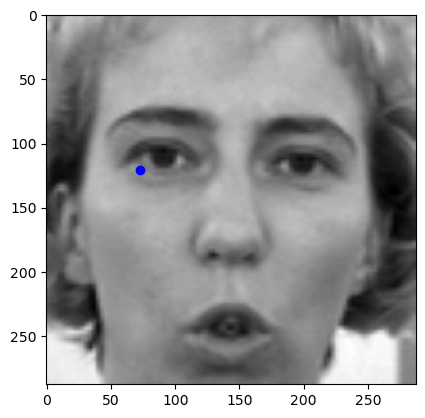

left_eyebrow_inner_end


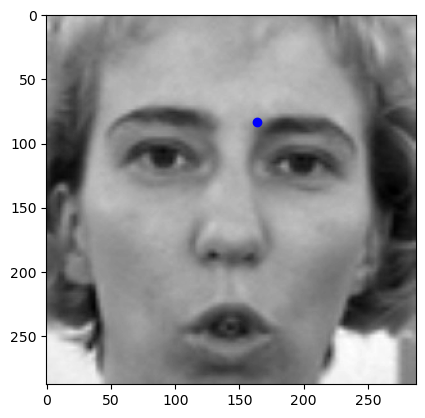

left_eyebrow_outer_end


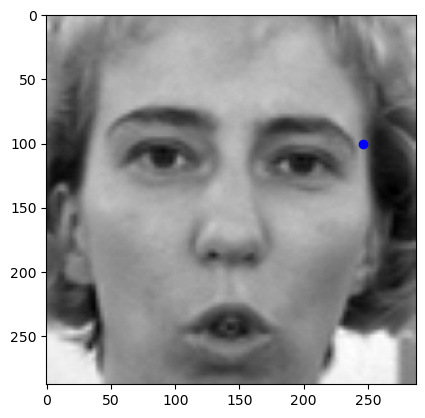

right_eyebrow_inner_end


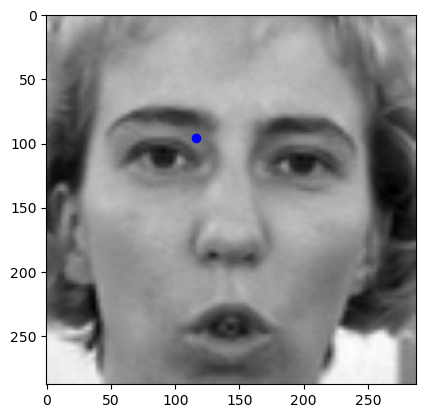

right_eyebrow_outer_end


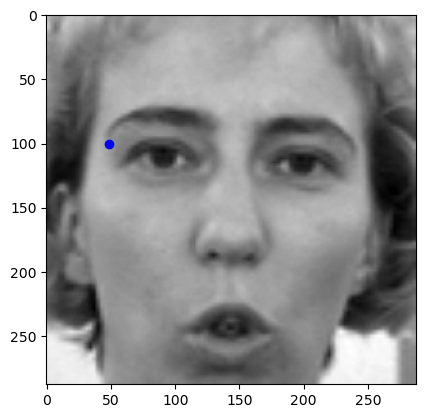

nose_tip


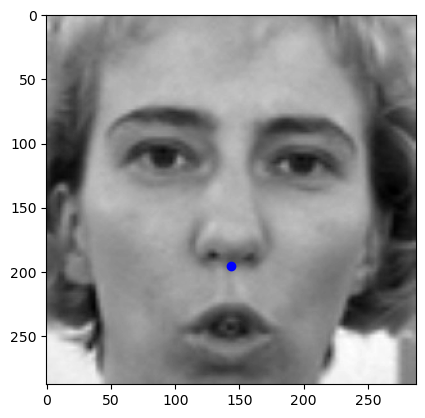

mouth_left_corner


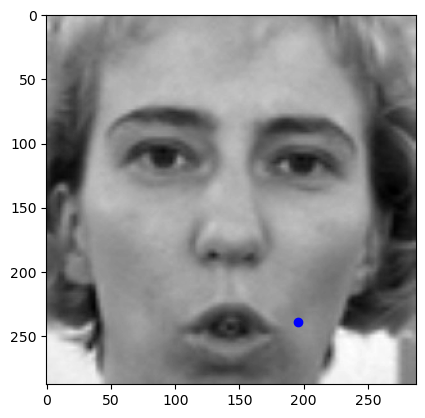

mouth_right_corner


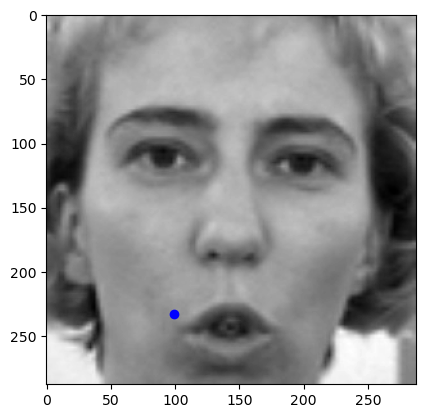

mouth_center_top_lip


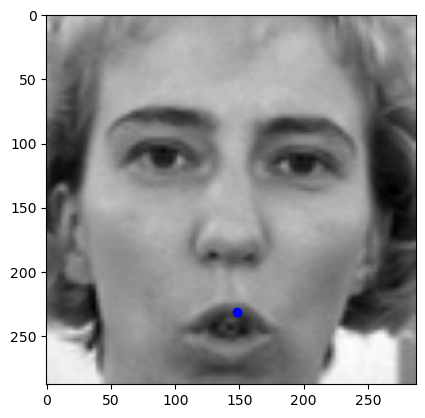

mouth_center_bottom_lip


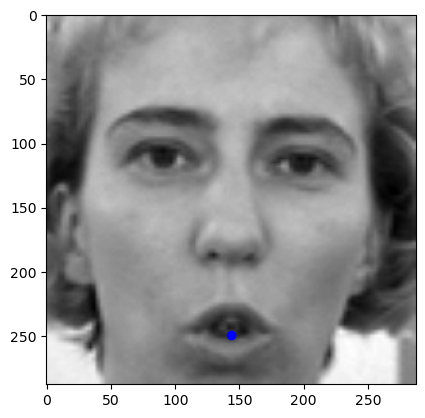

In [72]:
def model_output_to_keypoints_coordinates(output: np.array) -> dict:
    ret = {}
    for i, keypoint_name in enumerate(keypoints_names):
        keypoint_coordinates = output[0][(i*2):(2*i+2)]
        ret[keypoint_name] = keypoint_coordinates
    return ret

keyps = model_output_to_keypoints_coordinates(res)
for key_name in keypoints_names:
    print(key_name)
    display_image_with_keypoints(img, keyps[key_name])

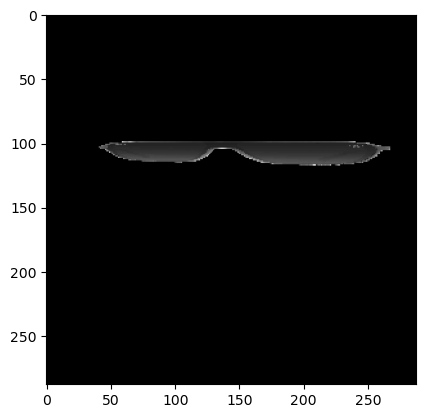

In [81]:
import json

class Filter:
    def __init__(self, json_descr_path: str):
        with open(json_descr_path, 'r') as f:
            data = json.load(f)
            self.image = cv2.imread(f"filters/{data['file_path']}")
            self.ref_points = data['reference_points']
    def show_image(self):
        plt.imshow(cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB))
    def warp_to_points(self, points: dict) -> np.array:
        dst = []
        src = []
        for keypoint_name in self.ref_points:
            if keypoint_name in points:
                dst.append(points[keypoint_name] * INPUT_SHAPE[0])
                src.append(self.ref_points[keypoint_name])
        assert len(dst) == len(src) == 4
        src = np.array(src, dtype=np.float32)
        dst = np.array(dst, dtype=np.float32)
        matrix = cv2.getPerspectiveTransform(src, dst)
        return cv2.warpPerspective(self.image, matrix, (INPUT_SHAPE[0], INPUT_SHAPE[1]))

glasses = Filter('filters/sunglasses.json')
glasses_warped = cv2.cvtColor(glasses.warp_to_points(keyps), cv2.COLOR_BGR2GRAY)
plt.imshow(glasses_warped, cmap='gray')

(288, 288) (288, 288)


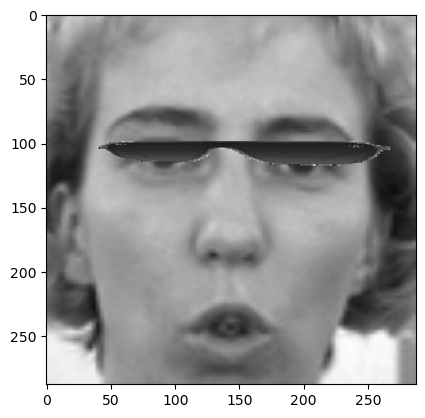

In [91]:
def combine_image_and_filter(img: np.array, filter: np.array) -> np.array:
    pseudo_alpha_filter = (filter > 0).astype(np.uint8)
    inverse_pseudo_alpha_filter = np.ones(INPUT_SHAPE[:2]) - pseudo_alpha_filter
    return filter * pseudo_alpha_filter + inverse_pseudo_alpha_filter * img.squeeze()

plt.imshow(combine_image_and_filter(img, glasses_warped), cmap = 'gray')